In [1]:
# Transformations for modeling

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [41]:
touse = pd.read_csv("gamedata.csv")

#touse.isnull().sum()


- We need to dropna in possession time, there are only 7 accounts of this but no explanation as to why a team would not have zerp possession time alongside stats. Then we will fill all other na values with 0 as we have determined that null values are equivalent to 0.

In [190]:
# touse['possessionTime'] = touse['possessionTime'].fillna('00:00')

touse = touse.dropna(subset=['possessionTime'])

cleaned = touse.fillna(0)

#cleaned.isnull().sum()

- We need to drop the 'Game Id' column

In [191]:
dropped = cleaned.drop(columns = ["Game Id"])

#dropped


- Assign dataframe to new name

In [192]:
test = dropped

# print(test['possessionTime'].to_string())

- We need to create a function to get possession time into seconds from a string.

In [193]:
# change possession time to seconds

def get_seconds(time_str):
    w = np.array([time_str.split(':')])
    mm,ss = w[:,0],w[:,1]
    return int(mm) * 60 + int(ss)



- We need to apply function rowwise and save to new column

In [194]:
test['newposs'] = test.loc[:,'possessionTime'].apply(lambda row: get_seconds(str(row)))


#test[['possessionTime','newposs']]

- We need to drop old column for possessiontime and rename new one as same

In [196]:
changedtime = test.drop(columns = ["possessionTime"])

changedtime = changedtime.rename(columns={'newposs':'possessionTime'})

#changedtime.head()

- We need to convert categorical variables into dummy variables to regress on. We cannot just use label enconder as the model will learn untrue relations in the categorical variables, such as order

- Next, we need to standardize our continous variables so that they are on the same scale but we need to remove dummies and target before

- Lastly, we need to put the dataframe back together with our dummmies and target

In [197]:
# label_encoder = LabelEncoder()

# changedtime[['Conference','HomeAway','School']] = changedtime[['Conference','HomeAway','School']].apply(LabelEncoder().fit_transform)

changedtime = pd.get_dummies(changedtime)

tostandardize = changedtime.iloc[:,1:30]

scaler = StandardScaler()

standed = scaler.fit_transform(tostandardize)

standeddf = pd.DataFrame(standed,columns = tostandardize.columns)

# standeddf[['Conference','HomeAway']] = changedtime[['Conference','HomeAway']]

#standeddf.head()

a = pd.DataFrame(changedtime.iloc[:,0])

b = pd.DataFrame(changedtime.iloc[:,31:])

# standeddf.iloc[:,:30]

standeddf = pd.concat([a,standeddf,b],axis=1)

standeddf.head()


,Points,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionYards,interceptions,kickReturnYards,kickReturns,...,School_Washington State,School_West Virginia,School_Wisconsin,Conference_ACC,Conference_Big 12,Conference_Big Ten,Conference_Pac-12,Conference_SEC,HomeAway_away,HomeAway_home
0,50,0.843324,2.138957,1.454368,1.792974,0.269676,-0.508726,-0.847351,0.278951,-0.093289,...,False,False,False,True,False,False,False,False,False,True
1,41,-0.282079,1.130084,-0.971987,-0.751678,0.269676,0.642740,-0.847351,0.499631,0.476317,...,False,False,False,True,False,False,False,False,False,True
2,28,0.815767,0.457501,1.454368,0.520648,-0.666193,-0.508726,-0.847351,0.646751,0.476317,...,False,False,False,True,False,False,False,False,False,True
3,28,0.529171,-0.383227,0.241191,-0.751678,-0.666193,-0.364793,-0.847351,1.137150,0.476317,...,False,False,False,True,False,False,False,False,False,True
4,60,1.300450,1.466375,0.847779,-0.751678,-0.666193,0.834651,-0.847351,1.137150,0.476317,...,False,False,False,True,False,False,False,False,False,True


In [49]:
#standeddf.dtypes

- We need to learn which variable is correlated most with the dependent target variable. This will give us a basis regression model that we can hope to improve. 

In [224]:
mat = standeddf.corr(method='pearson')


uppcor = mat.where(np.triu(np.ones(mat.shape), k=1).astype(bool))

uniq = uppcor.unstack().dropna()

sormat = uniq.sort_values(ascending =False)

sormat.shape

abs(mat['Points']).sort_values(ascending=False).nlargest(10)

Points                 1.000000
totalYards             0.802558
firstDowns             0.653798
yardsPerPass           0.614064
rushingYards           0.572163
thirdDownEff           0.533052
yardsPerRushAttempt    0.500529
completionAttempts     0.483505
netPassingYards        0.480468
rushingAttempts        0.311768
Name: Points, dtype: float64

- We need to check our variables for multicollinearity. We will do this by using the variance inflation factor

- Here we will just check and we see that there is indeed high multicollinearity

- We will deal with these two cells down

In [198]:
pd.set_option('display.max_rows',None)

takeouty = standeddf.iloc[:,1:30]

vifs = pd.Series(np.linalg.inv(takeouty.corr().to_numpy()).diagonal(),
                index=takeouty.columns,name="VIF")

abs(vifs).sort_values(ascending=False)

turnovers              3.316300e+14
totalYards             2.587407e+14
interceptions          1.892608e+14
netPassingYards        1.640541e+14
rushingYards           1.394029e+14
fumblesLost            1.387461e+14
penaltyYards           5.308729e+00
firstDowns             5.292531e+00
totalPenalties         5.279858e+00
rushingAttempts        4.439856e+00
yardsPerRushAttempt    4.183969e+00
kickReturns            3.936393e+00
kickReturnYards        3.778718e+00
yardsPerPass           2.960512e+00
completionAttempts     2.017977e+00
puntReturns            1.804563e+00
possessionTime         1.787103e+00
thirdDownEff           1.783566e+00
tacklesForLoss         1.748750e+00
totalFumbles           1.697552e+00
sacks                  1.690335e+00
puntReturnYards        1.642561e+00
passesIntercepted      1.583275e+00
interceptionYards      1.525794e+00
tackles                1.256343e+00
passesDeflected        1.137717e+00
qbHurries              1.108499e+00
fourthDownEff          1.081

- This is just validation of the vif using an intercept, the intercept has no impact on the vif scores

- The warning is fine, division was by extremely small number which creates the inf you see in the table

In [225]:
from patsy import dmatrices

yout = standeddf.iloc[:,1:30]

features = '+'.join(yout.columns)

y,X = dmatrices("Points ~" + features ,standeddf,return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values,i)for i in range(X.shape[1])]
vif['features'] = X.columns
vif.sort_values(by='VIF',ascending=False)

/Users/michaelguel/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF,features
4,inf,fumblesLost
24,inf,turnovers
7,inf,interceptions
10,inf,netPassingYards
23,inf,totalYards
17,inf,rushingYards
28,5.308729,penaltyYards
2,5.292531,firstDowns
27,5.279858,totalPenalties
16,4.439856,rushingAttempts


- We are now going to iteratively remove high vif variables

- We will start with the greatest vif, remove and continue to the next highest vif

- This will continue until we reach a set of variables that all vif are < 2.5

In [200]:
col = ['turnovers','totalYards','rushingYards','penaltyYards','netPassingYards','kickReturns']

tryagain = takeouty[takeouty.columns[~takeouty.columns.isin(col)]]

vifs = pd.Series(np.linalg.inv(tryagain.corr().to_numpy()).diagonal(),
                index=tryagain.columns,name="VIF")

abs(vifs).sort_values(ascending=False)



firstDowns             2.185928
completionAttempts     1.998600
puntReturns            1.780558
thirdDownEff           1.769318
yardsPerPass           1.751741
possessionTime         1.749949
tacklesForLoss         1.745198
rushingAttempts        1.740385
totalFumbles           1.684858
sacks                  1.683046
puntReturnYards        1.635736
fumblesLost            1.582962
passesIntercepted      1.571982
interceptionYards      1.520574
yardsPerRushAttempt    1.296518
tackles                1.246486
interceptions          1.138035
passesDeflected        1.131372
qbHurries              1.105242
fourthDownEff          1.075703
kickReturnYards        1.065970
fumblesRecovered       1.058791
totalPenalties         1.029934
Name: VIF, dtype: float64

- We will use the remaining variables after vif to construct a new dataframe that has little multicollinearity

- Assign both revised dataframe and original to new names to be used in the models

In [228]:
vifx = pd.concat([tryagain,b],axis=1)

full = standeddf.iloc[:,1:]

y = pd.DataFrame(standeddf.iloc[:,0])

In [229]:
X = full

Y = y

start_state = 24

test_fraction = 0.2

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = test_fraction,random_state=start_state)

In [230]:
basis = LinearRegression()

basismodel = basis.fit(X_train[['totalYards']],y_train)

print(basismodel.score(X_test[['totalYards']],y_test))

print(cross_val_score(basis,X[['totalYards']],Y,cv=5))

0.6422712619463535
[0.60131278 0.65648358 0.63638049 0.63993667 0.66748286]


In [231]:
estimator1 = LinearRegression()

model1 = estimator1.fit(X_train,y_train)

print(model1.score(X_test,y_test))

print(cross_val_score(estimator1,X,Y,cv=5))

0.7786444888122558
[ 7.39169462e-01 -4.38622482e+19  7.75199315e-01  7.41763289e-01
  7.97634446e-01]


In [232]:
estimator2 = DecisionTreeRegressor()

model2 = estimator2.fit(X_train,y_train)

print(model2.score(X_test,y_test))

print(cross_val_score(estimator2,X,Y,cv=5))

0.4416673446072009
[0.45814737 0.47555234 0.49482162 0.46775037 0.52678546]


In [233]:
estimator3 = RandomForestRegressor(n_estimators=100)

model3 = estimator3.fit(X_train,np.ravel(y_train))

print(model3.score(X_test,y_test))

print(cross_val_score(estimator3,X,np.ravel(Y),cv=5))

0.7459463689573976
[0.72976585 0.76512071 0.76184173 0.75444421 0.77688249]


In [234]:
estimator4 = xgb.XGBRegressor(objective='reg:squarederror')

model4 = estimator4.fit(X_train,y_train)

print(model4.score(X_test,y_test))

print(cross_val_score(estimator4,X,Y,cv=5))

0.7379992625900846
[0.72546821 0.75997871 0.75693882 0.74529036 0.7816779 ]


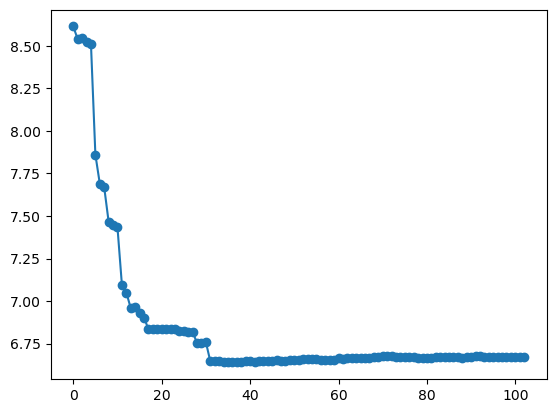

In [256]:
pca = PCA()

X_train_pc = pca.fit_transform(X_train)

#print(pca.explained_variance_ratio_)

rmse_list = []

for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(estimator1,X_train_pc[:,:i],
                                     y_train,
                                     scoring = 'neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)

plt.plot(rmse_list,'-o')

In [257]:
pcnum = 35

model5 = LinearRegression().fit(X_train_pc[:,:pcnum],y_train)

X_test_pc = pca.transform(X_test)[:,:pcnum]

print(model5.score(X_test_pc,y_test))

X_cross_pc = pca.transform(X)

print(cross_val_score(estimator1,X_cross_pc,Y,cv=5))

0.7791284380692346
[0.74030112 0.70259101 0.77527401 0.74095701 0.7981166 ]
